# <center>Использование различных методов оптимизации поиска гиперпараметров модели
# <center>Предсказание биологического ответа молекул
## Знакомство с данными
[kaggle](https://www.kaggle.com/c/bioresponse)

In [78]:
import pandas as pd
import numpy as np
import plotly.io as pio
import optuna

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from hyperopt import hp, fmin, tpe, Trials, space_eval

In [79]:
pio.renderers.default = 'png'

In [2]:
data = pd.read_csv('data/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


* Первый столбец `Activity` содержит экспериментальные данные, описывающие фактический биологический ответ `[0, 1]`; 
* Остальные столбцы `D1-D1776` представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Проверим пропуски в данных

In [5]:
data.isna().sum().nlargest(5)

Activity    0
D1          0
D2          0
D3          0
D4          0
dtype: int64

Проверим сбалансированность классов

In [6]:
data['Activity'].value_counts(normalize=True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

Классы сбалансированы, стратификация не понадобится.
Т.к. данные предварительно обработаны, сразу же перейдём к этапу построения моделей.

## Logistic regression
### Базовый случай

In [20]:
# Определяем константы для всего проекта
RANDOM_STATE = 42
TARGET_METRIC = 'f1'
N_JOBS = -1
# Разделяем выборки
X, y = data.drop(columns='Activity'), data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
# Создаем объект кросс валидации
kfold = KFold(n_splits=10)
# Создаем базовую модель логистической регрессии
logreg_model = LogisticRegression(random_state=RANDOM_STATE, n_jobs=N_JOBS)
# Считаем метрики кросс-валидации
%time
cv_metrics = cross_validate(
    estimator=logreg_model,
    X=X_train,
    y=y_train,
    cv=kfold,
    return_train_score=True,
    n_jobs=N_JOBS,
    scoring=TARGET_METRIC
)
# Делаем предсказание для тестовой выборки
logreg_model.fit(X_train, y_train)
y_test_pred = logreg_model.predict(X_test)

print('Train F1-score CV:', cv_metrics['train_score'].mean().round(2))
print('Validation F1-score CV:', cv_metrics['test_score'].mean().round(2))
print('Test F1-score:', metrics.f1_score(y_test, y_test_pred).round(2))

CPU times: total: 0 ns
Wall time: 0 ns
Train F1-score CV: 0.89
Validation F1-score CV: 0.78
Test F1-score: 0.79


### GridSearchCV

In [29]:
param_grid = [
    {
        'penalty': np.array(['l2', 'none']),
        'solver': np.array(['lbfgs', 'newton-cg', 'sag']),
        'C': np.linspace(0.01, 5, 15)
    }
]
# Зададим поменьше фолдов для валидации, чтобы уменьшить время обучения
kfold = KFold(n_splits=5)
gridsearch = GridSearchCV(
    estimator=LogisticRegression(
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        max_iter=500
    ),
    cv=kfold,
    param_grid=param_grid,
    n_jobs=N_JOBS
)
# Обучаем модель на сетке параметров
%time gridsearch.fit(X_train, y_train)
y_test_pred = gridsearch.predict(X_test)
print('Best test F1-score on GridSearchCV:', metrics.f1_score(y_test, y_test_pred).round(2))
print('Best params on GridSearchCV:', gridsearch.best_params_)

CPU times: total: 4.11 s
Wall time: 10min 51s
Best test F1-score on GridSearchCV: 0.8
Best params on GridSearchCV: {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}


### RandomizedSearchCV

In [31]:
rand_gridsearch = RandomizedSearchCV(
    estimator=LogisticRegression(
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        max_iter=500
    ),
    cv=kfold,
    param_distributions=param_grid,
    n_jobs=N_JOBS,
    n_iter=20
)
# Обучаем модель на сетке параметров
%time rand_gridsearch.fit(X_train, y_train)
y_test_pred = rand_gridsearch.predict(X_test)
print('Best test F1-score on RandomizedSearchCV:', metrics.f1_score(y_test, y_test_pred).round(2))
print('Best params on RandomizedSearchCV:', rand_gridsearch.best_params_)

CPU times: total: 16.5 s
Wall time: 4min 1s
Best test F1-score on RandomizedSearchCV: 0.78
Best params on RandomizedSearchCV: {'solver': 'sag', 'penalty': 'l2', 'C': 3.9307142857142856}


C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Промежуточный вывод
>`GridSearchCV` на тестовой выборке показал результат $F_1 = 0.8$ и потратил 10 минут времени на прогон всех параметров.  
>`RandomizedSearchCV` на тестовой выборке показал результат $F_1 = 0.78$ и потратил 4 минуты на 20 итераций.

Благодаря `GridSearchCV` можно заметить, что коэффициент регуляризации `C` в данном случае лучше брать $<1$, это улучшает метрику. Будем отталкиваться от этого, подбирая параметры с помощью следующих способов.

### Hyperopt

In [55]:
def hyperopt_logreg(params, cv=kfold, X=X_train, y=y_train):
    model = LogisticRegression(**params, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    # кросс-валидация
    score = cross_val_score(model, X, y, cv=cv, scoring=TARGET_METRIC, n_jobs=N_JOBS).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

params = {
    'penalty': hp.choice('penalty', ['l2', 'none']),
    'solver': hp.choice('solver', ['lbfgs', 'newton-cg', 'sag']),
    'C': hp.uniform('C', 0.001, 1)
}
trials = Trials()

best_hp = fmin(
    hyperopt_logreg, 
    space=params,
    algo=tpe.suggest,
    max_evals=40,
    trials=trials, 
    rstate=np.random.default_rng(RANDOM_STATE)
)
best_params_hp = space_eval(params, best_hp)
print('Best params Hyperopt:', best_params_hp)

100%|██████████| 40/40 [01:27<00:00,  2.18s/trial, best loss: -0.7852643220890639]
Best params Hyperopt: {'C': 0.042219097013541804, 'penalty': 'l2', 'solver': 'lbfgs'}


In [56]:
# Подставим лучшие параметры Hyperopt в модель и посчитаем F1-score для тестовой выборки
logreg_model = LogisticRegression(
    **best_params_hp,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

logreg_model.fit(X_train, y_train)
y_test_pred = logreg_model.predict(X_test)
print('Best test F1-score on Hyperopt:', metrics.f1_score(y_test, y_test_pred).round(2))

Best test F1-score on Hyperopt: 0.8


### Optuna

In [57]:
def optuna_logreg(trial, cv=kfold, X=X_train, y=y_train):
    # задаем пространства поиска гиперпараметров
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l2', 'none']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag']),
        'C': trial.suggest_float('C', 0.001, 1)
    }
    # создаем модель
    model = LogisticRegression(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    )
    # кросс-валидация
    score = cross_val_score(model, X, y, cv=cv, scoring=TARGET_METRIC, n_jobs=N_JOBS).mean()

    return score

study = optuna.create_study(study_name='LogisticRegression', direction='maximize')
study.optimize(optuna_logreg, n_trials=40)
# Обучаем модель на лучших параметрах от Optuna
logreg_model = LogisticRegression(
    **study.best_params,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)
logreg_model.fit(X_train, y_train)
y_test_pred = logreg_model.predict(X_test)

print('Best params Optuna:', study.best_params)
print('Best test F1-score on Optuna:', metrics.f1_score(y_test, y_test_pred).round(2))

[I 2023-03-22 19:44:03,826] A new study created in memory with name: LogisticRegression
[I 2023-03-22 19:44:08,313] Trial 0 finished with value: 0.7698427175392597 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.684775781132478}. Best is trial 0 with value: 0.7698427175392597.
[I 2023-03-22 19:44:36,677] Trial 1 finished with value: 0.7164780378883997 and parameters: {'penalty': 'none', 'solver': 'newton-cg', 'C': 0.8849063702714159}. Best is trial 0 with value: 0.7698427175392597.
[I 2023-03-22 19:44:40,273] Trial 2 finished with value: 0.7821838418407102 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.07618117154212914}. Best is trial 2 with value: 0.7821838418407102.
[I 2023-03-22 19:45:06,997] Trial 3 finished with value: 0.7164780378883997 and parameters: {'penalty': 'none', 'solver': 'newton-cg', 'C': 0.39449748353123953}. Best is trial 2 with value: 0.7821838418407102.
[I 2023-03-22 19:45:09,795] Trial 4 finished with value: 0.781433882833453 and parameters

Best params Optuna: {'penalty': 'l2', 'solver': 'sag', 'C': 0.04354083564393391}
Best test F1-score on Optuna: 0.8


C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Визуализация оптимизации и самых важных гиперпараметров с помощью Optuna

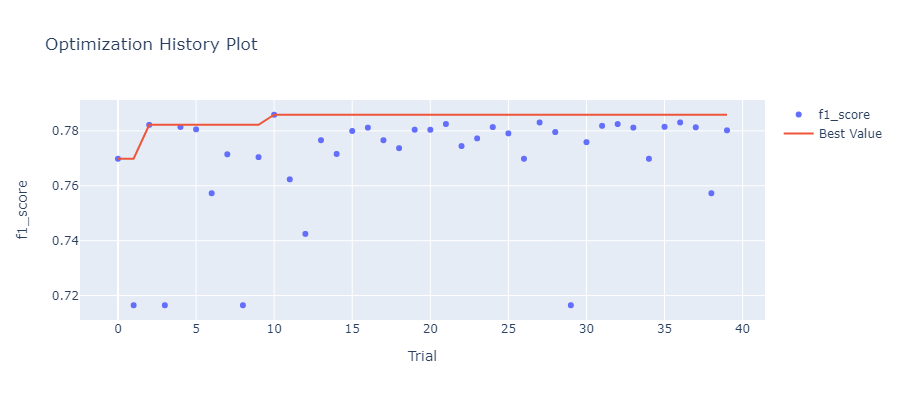

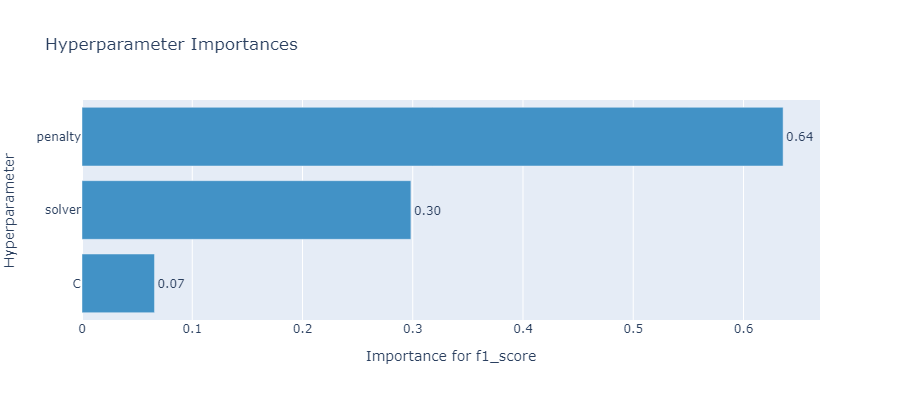

In [81]:
fig_opt_hist = optuna.visualization.plot_optimization_history(study, target_name="f1_score")
fig_param_imp = optuna.visualization.plot_param_importances(study, target_name="f1_score")
fig_opt_hist.update_layout(width=900, height=400)
fig_param_imp.update_layout(width=900, height=400)
fig_opt_hist.show()
fig_param_imp.show()

### Промежуточный вывод
По целевой метрике на тестовой выборке `Optuna` и `Hyperopt` не отличаются от `GridSearchCV`, однако занимают гораздо меньше времени. `RandomSearchCV` показал результат $F_1$ хуже на $0.02$.  
От параметра `solver` практически ничего не зависит в данном случае.
Что `sag`, что `lbfgs` показывают одинаковый результат, а `newton-cg` не был выбран ни одним методом в словарь лучших гиперпараметров.  
Наилучшим типом регуляризации `penalty` был выбран `l2` во всех методах оптимизации.

## Random forest
### Базовый случай

In [58]:
rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)
# Кросс-валидация
cv_metrics = cross_validate(
    rf_model,
    X=X_train,
    y=y_train,
    scoring=TARGET_METRIC,
    cv=kfold,
    return_train_score=True,
    n_jobs=N_JOBS
)
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)

print('Train F1-score CV RandomForest:', cv_metrics['train_score'].mean().round(2))
print('Validation F1-score CV RandomForest:', cv_metrics['test_score'].mean().round(2))
print('Test F1-score RandomForest:', metrics.f1_score(y_test, y_test_pred).round(2))

Train F1-score CV RandomForest: 1.0
Validation F1-score CV RandomForest: 0.81
Test F1-score RandomForest: 0.83


### GridSearchCV

In [74]:
param_grid = {
    'criterion': np.array(['gini', 'entropy']),
    'max_depth': np.arange(5, 16),
    'min_samples_leaf': np.array([1, 5, 20])
}

gridsearch_rf = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    ),
    param_grid=param_grid,
    scoring=TARGET_METRIC,
    cv=kfold,
    n_jobs=N_JOBS
)

%time gridsearch_rf.fit(X_train, y_train)
y_test_pred = gridsearch_rf.predict(X_test)

print('Best params for RandomForest on GridSearchCV:', gridsearch_rf.best_params_)
print('Best CV F1-score for RandomForest on GridSearchCV:', gridsearch_rf.best_score_.round(2))
print('Best test F1-score for RandomForest on GridSearchCV:', metrics.f1_score(y_test, y_test_pred).round(2))

CPU times: total: 17.8 s
Wall time: 5min 3s
Best params for RandomForest on GridSearchCV: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1}
Best CV F1-score for RandomForest on GridSearchCV: 0.81
Best test F1-score for RandomForest on GridSearchCV: 0.84


### RandomizedSearchCV

In [82]:
randsearch_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    ),
    param_distributions=param_grid,
    scoring=TARGET_METRIC,
    cv=kfold,
    n_jobs=N_JOBS,
    n_iter=50
)

%time randsearch_rf.fit(X_train, y_train)
y_test_pred = randsearch_rf.predict(X_test)

print('Best params for RandomForest on RandomizedSearchCV:', randsearch_rf.best_params_)
print('Best CV F1-score for RandomForest on RandomizedSearchCV:', randsearch_rf.best_score_.round(2))
print('Best test F1-score for RandomForest on RandomizedSearchCV:', metrics.f1_score(y_test, y_test_pred).round(2))

CPU times: total: 17.5 s
Wall time: 3min 48s
Best params for RandomForest on RandomizedSearchCV: {'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'entropy'}
Best CV F1-score for RandomForest on RandomizedSearchCV: 0.81
Best test F1-score for RandomForest on RandomizedSearchCV: 0.84


### Промежуточный вывод
`RandomizedSearchCV` показал себя лучше, чем `GridSearchCV`, т.к. выдал аналогичный результат, потратив меньше времени.
### Hyperopt 

In [88]:
def hyperopt_rf(params, cv=kfold, X=X_train, y=y_train):  
    model = RandomForestClassifier(**params, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    # кросс-валидация
    score = cross_val_score(model, X, y, cv=cv, scoring=TARGET_METRIC, n_jobs=N_JOBS).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

params = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', np.arange(5, 16)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 21)),
    'n_estimators': hp.choice('n_estimators', np.arange(50, 251, 50))
}
trials = Trials()

best_hp = fmin(
    hyperopt_rf, 
    space=params,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials, 
    rstate=np.random.default_rng(RANDOM_STATE)
)
best_params_hp = space_eval(params, best_hp)
# Создаем модель с лучшими параметрами от Hyperopt и обучаем
rf_model = RandomForestClassifier(
    **best_params_hp,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)

print('Best params Hyperopt:', best_params_hp)
print('Best test F1-score on Hyperopt:', metrics.f1_score(y_test, y_test_pred).round(2))

100%|██████████| 50/50 [06:10<00:00,  7.40s/trial, best loss: -0.81014356583591]  
Best params Hyperopt: {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 2, 'n_estimators': 150}
Best test F1-score on Hyperopt: 0.83


### Optuna

In [89]:
def optuna_rf(trial, cv=kfold, X=X_train, y=y_train):
    # задаем пространства поиска гиперпараметров
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 16),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 21),
        'n_estimators': trial.suggest_int('n_estimators', 50, 251, step=50)
    }
    # создаем модель
    model = RandomForestClassifier(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    )
    # кросс-валидация
    score = cross_val_score(model, X, y, cv=cv, scoring=TARGET_METRIC, n_jobs=N_JOBS).mean()

    return score

study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=50)
# Обучаем модель на лучших параметрах от Optuna
rf_model = RandomForestClassifier(
    **study.best_params,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)

print('Best params Optuna:', study.best_params)
print('Best test F1-score on Optuna:', metrics.f1_score(y_test, y_test_pred).round(2))

[I 2023-03-22 22:24:35,899] A new study created in memory with name: RandomForestClassifier
C:\Users\sadeyes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\distributions.py:716: UserWarning:

The distribution is specified by [50, 251] and step=50, but the range is not divisible by `step`. It will be replaced by [50, 250].

[I 2023-03-22 22:24:42,224] Trial 0 finished with value: 0.7681744624526841 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 11, 'n_estimators': 100}. Best is trial 0 with value: 0.7681744624526841.
[I 2023-03-22 22:24:47,715] Trial 1 finished with value: 0.7815878382258092 and parameters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 14, 'n_estimators': 100}. Best is trial 1 with value: 0.7815878382258092.
[I 2023-03-22 22:24:50,703] Trial 2 finished with value: 0.7964954985549216 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_sample

Best params Optuna: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 2, 'n_estimators': 200}
Best test F1-score on Optuna: 0.84


#### Визуализация оптимизации и самых важных гиперпараметров с помощью Optuna

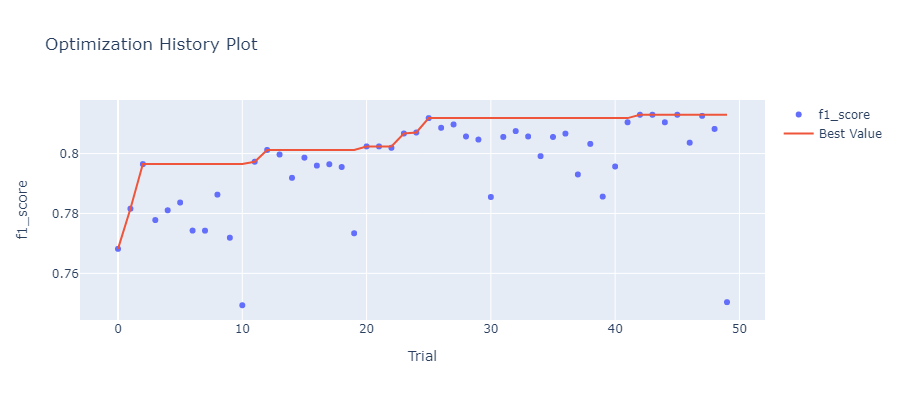

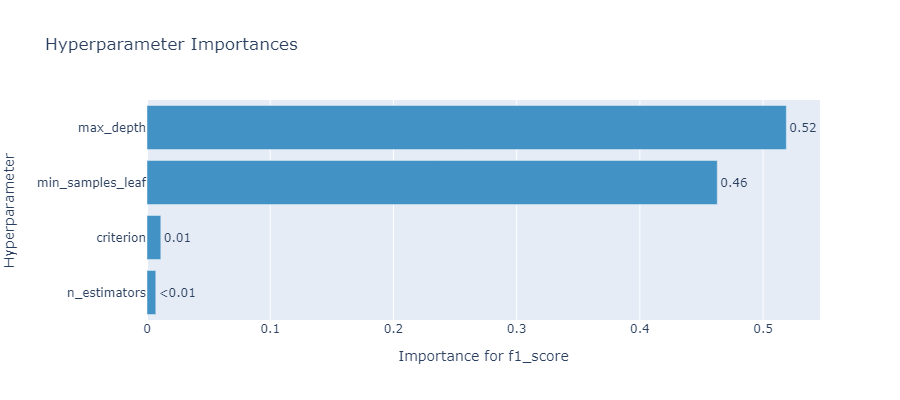

In [90]:
fig_opt_hist = optuna.visualization.plot_optimization_history(study, target_name="f1_score")
fig_param_imp = optuna.visualization.plot_param_importances(study, target_name="f1_score")
fig_opt_hist.update_layout(width=900, height=400)
fig_param_imp.update_layout(width=900, height=400)
fig_opt_hist.show()
fig_param_imp.show()

## Выводы по проделанной работе
* `GridSearchCV` очень полезен, если нужно перебрать все возможные варианты, и у нас есть достаточно времени на это;
* `RandomSearchCV` позволяет выбрать приблизительные значения для гиперпараметров, которые дадут наиболее высокую метрику из всех случайных итераций, после чего отталкиваться на основе этих значений, например, с помощью более продвинутых методов;
* `Hyperopt` и `Optuna` очень похожи между собой как по скорости, так и по алгоритму работы, но `Optuna` имеет более *user-friendly* документацию и менее сложен в реализации, чем `Hyperopt`, вдобавок к этому имеет встроенную визуализацию;
* `RandomForestClassifier` показал более высокий показатель метрики на тестовой выборке, в отличии от `LogisticRegression`, что вполне ожидаемо, т.к. реализует в себе *бэггинг*.